<a href="https://colab.research.google.com/github/truptisatsangi/ONLINE-ATTENDENCE-SYSTEM/blob/main/C_OAS_with_dummy_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MOUNTING THE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install mtcnn

     |████████████████████████████████| 2.3 MB 5.5 MB/s 


In [ ]:
from matplotlib import pyplot as plt
from mtcnn.mtcnn import MTCNN
from PIL import Image
import numpy as np
from numpy import load, expand_dims,  asarray, savez_compressed 
from keras.models import load_model
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from PIL import Image




In [ ]:
## making our drive our working current directory
import os
%cd /content/drive/My\ Drive/
print(os.listdir("../My Drive"))

/content/drive/My Drive
['Getting started.pdf', 'Colab Notebooks', 'Classroom', 'face_2_download.jpg', 'face_download.jpg', 'my_pic.jpg', 'faces_for_face_reconition', 'Drowsiness detection.zip (Unzipped Files)', 'emotion detection', 'EMOTION_DETECTION', 'devfest-india-certificate.pdf', 'Resume_Trupti.pdf', 'images.jpg', ' IT-2K18-55_Trupti satsangi.pdf', 'dataset for OAS.npz', 'Attendance sheet for OAS (1).gsheet', 'Attendance sheet for OAS.gsheet', 'Untitled form (File responses)', 'Untitled form.gform', 'ADS 55_trupti satsangi.pdf', 'IT-2k18-55.pdf', 'javalab_IT-2k18-55.pdf', 'M.tech 18 dataset', 'Screenshot_2021-02-17-20-37-06-767_com.instagram.android.png', 'Screenshot_2021-02-17-20-36-57-212_com.instagram.android.png', 'Screenshot_2021-02-17-20-36-39-799_com.instagram.android.png', 'Screenshot_2021-02-17-20-36-53-890_com.instagram.android.png', 'Screenshot_2021-02-17-20-36-34-815_com.instagram.android.png', 'lab_IT-2k18-55.pdf', 'face dataset embeddings.npz', 'dataset for OAS_Mtec

In [ ]:

# function for face detection with mtcnn

 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array


In [ ]:

# folder = 'dummy dataset for OAS/train/Ratan tata/'
# i = 1 
# for filename in os.listdir(folder):
#   path = folder + filename
#   face = extract_face(path)
#   print(i, face.shape)
#   plt.subplot(4, 5, i)
#   plt.axis('off')
#   plt.imshow(face)
#   i += 1
# plt.show()

In [ ]:
# ONLY FACES OF ONE PERSON IS EXTRACTED 

def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in os.listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

In [ ]:
# MAKING DATABASES OF ALL PEOPLE IN DATASET 
# X STORES THE IMAGES AND Y STORES THE LABELS

def load_dataset(directory):
  X,y = list(), list()
  
  # THIS LOOP ITERATES OVER TRAIN AND VAL DIRECORY
  for subdir in os.listdir(directory):
    path = directory + subdir + '/'           # PATHS FOR INDIVIDUAL PERSON
  
    faces = load_faces(path)
    # CREATING LABELS
    labels = [subdir for _ in range(len(faces))]
    print('>loaded %d examples for class: %s' % (len(faces), subdir))
    X.extend(faces)
    y.extend(labels)
  return asarray(X), asarray(y)



In [ ]:
# # MAKING DATASET OF TRAIN AND TEST DATA 
# # CALLING LOAD_DATSET FUNCTION

# trainX,trainy = load_dataset('dummy dataset for OAS/train/')
# print(trainX.shape,trainy.shape)
# # LOAD TEST DATASET
# testX, testy = load_dataset('dummy dataset for OAS/val/')
# print(testX.shape,testy.shape)
# # SAVE ARRAYS TO ONE COMPRESSED FILE
# np.savez_compressed('dataset for OAS_dummy.npz',trainX,trainy, testX,testy)

>loaded 20 examples for class: Sundar pichai 
>loaded 20 examples for class: Ratan tata
>loaded 20 examples for class: Satya nadella
(60, 160, 160, 3) (60,)
>loaded 10 examples for class: Ratan tata
>loaded 10 examples for class: Satya nadella
>loaded 10 examples for class: Sundar pichai 
(30, 160, 160, 3) (30,)


In [ ]:

 
# get the face embedding for one face we use face_net_model
def get_embedding(face_net_model, face_pixels):

	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std 
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = face_net_model.predict(samples)
 
	return yhat[0]

In [ ]:
#     # load the face dataset
# data = load('dataset for OAS_dummy.npz')
# trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# # load the facenet model
# face_net_model = load_model('dataset for OAS/facenet_keras.h5')
# print('Loaded Model')
# # convert each face in the train set to an embedding
# newTrainX = list()
# for face_pixels in trainX:
#   print("fp",face_pixels.shape)
#   embedding = get_embedding(face_net_model, face_pixels)  
#   newTrainX.append(embedding)           # CALLING get_embedding FUNCTION WHICH IS DEFINED IN THE LAST CELL
	
	
# newTrainX = asarray(newTrainX)
# print(newTrainX.shape)
# # convert each face in the test set to an embedding
# newTestX = list()
# for face_pixels in testX:
# 	embedding = get_embedding(face_net_model, face_pixels)
# 	newTestX.append(embedding)
# newTestX = asarray(newTestX)
# print(newTestX.shape)
# # save arrays to one file in compressed format
# savez_compressed('face dataset embeddings_OAS_dummy.npz', newTrainX, trainy, newTestX, testy)

In [ ]:

# # load dataset
# data = load('face dataset embeddings_OAS_dummy.npz')
# trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=60, test=30


In [ ]:

# from sklearn.preprocessing import Normalizer
# # normalize input vectors
# in_encoder = Normalizer(norm='l2')
# trainX = in_encoder.transform(trainX)
# testX = in_encoder.transform(testX)

In [ ]:
 #  from sklearn.preprocessing import LabelEncoder
# # label encode targets
# out_encoder = LabelEncoder()
# out_encoder.fit(trainy)
# trainy = out_encoder.transform(trainy)
# testy = out_encoder.transform(testy)

In [ ]:
# from sklearn import svm
# svm_model = svm.SVC(kernel='linear',probability=True)
# svm_model.fit(trainX, trainy)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
# from sklearn.metrics import accuracy_score
# # predict
# yhat_train = svm_model.predict(trainX)
# yhat_test = svm_model.predict(testX)
# # score
# score_train = accuracy_score(trainy, yhat_train)
# score_test = accuracy_score(testy, yhat_test)
# # summarize
# print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


In [ ]:
def extract_faces(filename, required_size=(160, 160)):
  # load image from file
  face_array =[]
  image = Image.open(filename)
  # convert to RGB, if needed
  image = image.convert('RGB')
  # convert to array
  pixels = asarray(image)
  # create the detector, using default weights
  detector = MTCNN()
  # detect faces in the image
  results = detector.detect_faces(pixels)
  for result in results:
    # extract the bounding box from the first face
    x1, y1, width, height = result['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array.append(asarray(image))

  return face_array

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Satya nadella (100.000)


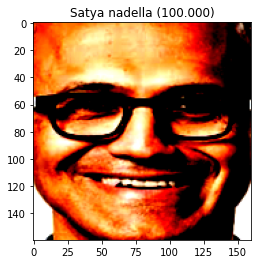

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Sundar pichai  (100.000)


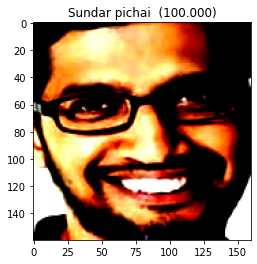

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Ratan tata (100.000)


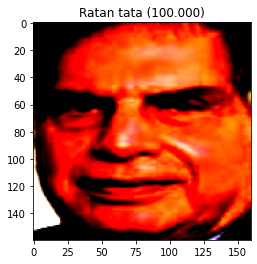

               0           1
0           NAME  30/11/2021
1                           
2     Ratan tata           p
3  Satya nadella           p
4  Sundar pichai           A


In [ ]:
# from random import choice
# TAKING TWO INPUTS ONE IS SCREENCSHOT PIC AND OTHER IS DATE
def result(image, input_date):
  # LOAD FACES 

  data = load('dataset for OAS_dummy.npz')
  testX_faces = image
  # load face embeddings
  data = load('face dataset embeddings_OAS_dummy.npz')
  trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

  # NORMALIZE  INPUT VECTOR

  in_encoder = Normalizer(norm='l2')
  trainX = in_encoder.transform(trainX)
  testX = in_encoder.transform(testX)

  # LABEL ENCODING

  out_encoder = LabelEncoder()
  out_encoder.fit(trainy)
  trainy = out_encoder.transform(trainy)
  testy = out_encoder.transform(testy)

  # FIT MODEL

  svm_model = SVC(kernel='linear', probability=True)
  svm_model.fit(trainX, trainy)

  img_pixels = extract_faces(image)             # EXTRACTING FACE FROM INPUT IMAGE

  face_net_model = load_model('dataset for OAS/facenet_keras.h5')     # LOADING FACENET MODEL
  all_titles = []
  for test_img_pixels in img_pixels:
    face_pixels = test_img_pixels.astype('float32')

    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    tface_pixels = (face_pixels - mean) / std
    emb = get_embedding(face_net_model, tface_pixels)
    test_samples = np.expand_dims(emb,axis = 0)
   

    test_yhat_class = svm_model.predict(test_samples)               # PREDICTING THE IMAGE
    test_yhat_prob = svm_model.predict_proba(test_samples)
    
    class_index = test_yhat_class[0]
    class_probability = test_yhat_prob[0,class_index] * 100
    predict_names = out_encoder.inverse_transform(test_yhat_class)
    print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
    pyplot.imshow(tface_pixels)
    title = '%s (%.3f)' % (predict_names[0], class_probability)
    pyplot.title(title)
    pyplot.show()
    all_titles.append(predict_names[0])                               # ALL THE NAMES PREDICTED

  
  attendance_sheet = gc.open('dummy sheet').sheet1                    # OPENING THE ATTENDANCE SHEET " DUMMY SHEET"

    # Get all values from the first row
  row_values_list = attendance_sheet.row_values(1)
 
  # Get all values from the first column
  col_values_list = attendance_sheet.col_values(1)
  
  date = attendance_sheet.find(input_date)                    # DATE SHOULD BE TAKEN FROM USER
  for title in all_titles:
    if (title in col_values_list):
      # print(title in col_values_list)
      cell = attendance_sheet.find(title)
      row_number = cell.row
      attendance_sheet.update_cell(row_number,date.col ,'p')      # UPDATATION FOR PRESENT STUDENT IS DONE HERE

  for col in col_values_list:
    if col not in all_titles:
      row_number = attendance_sheet.find(col).row
      attendance_sheet.update_cell(row_number,date.col ,'A')    # UPDATION FOR ABSENTEES ARE DONE HERE

  date_c = input_date                                         # DATE IS ALSO REQUIRED HERE
  attendance_sheet.update_cell(1,date.col,date_c)
  attendance_sheet.update_cell(2,date.col,"")
  data = attendance_sheet.get_all_values()
  df = pd.DataFrame(data)
  print(df)                                                     # PRINT OR RETURN THE SHEET

result("colab_oas.jpeg",'30/11/2021')